In [75]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [76]:
import matplotlib.pyplot as plt 
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [77]:
import seaborn as sns
import matplotlib.font_manager as fm

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지

---

### 데이터 불러오기

In [78]:
sort_total_years = pd.read_csv('sort_total_years.csv')

In [79]:
sort_like40 = sort_total_years[sort_total_years['year']=='1940y']
print('40년대 곡 개수 : ',len(sort_like40))
# sort_like40.head(2)

sort_like50 = sort_total_years[sort_total_years['year']=='1950y']
print('50년대 곡 개수 : ',len(sort_like50))
# sort_like50.head(2)

sort_like60 = sort_total_years[sort_total_years['year']=='1960y']
print('60년대 곡 개수 : ',len(sort_like60))
# sort_like60.head(2)

sort_like70 = sort_total_years[sort_total_years['year']=='1970y']
print('70년대 곡 개수 : ',len(sort_like70))
# sort_like70.head(2)

sort_like80 = sort_total_years[sort_total_years['year']=='1980y']
print('80년대 곡 개수 : ',len(sort_like80))
# sort_like80.head(2)

sort_like90 = sort_total_years[sort_total_years['year']=='1990y']
print('90년대 곡 개수 : ',len(sort_like90))
# sort_like90.head(2)

sort_like20 = sort_total_years[sort_total_years['year']=='2000y']
print('2000년대 곡 개수 : ',len(sort_like20))
# sort_like20.head(2)

sort_like2010 = sort_total_years[sort_total_years['year']=='2010y']
print('2010년대 곡 개수 : ',len(sort_like2010))
# sort_like2010.head(2)

40년대 곡 개수 :  98
50년대 곡 개수 :  98
60년대 곡 개수 :  88
70년대 곡 개수 :  179
80년대 곡 개수 :  339
90년대 곡 개수 :  572
2000년대 곡 개수 :  1028
2010년대 곡 개수 :  906


---

## 신조어  

In [80]:
from ckonlpy.tag import Twitter
twitter = Twitter()

In [81]:
len(add_words)

236

### 불용어

In [82]:
 # 불용어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하','부터','처럼','까지',
          'know','no','of','let','my','수','너','내','나','그','난','봐',
          '돼','건','모든','에서','에게','싶어','잖아',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기',
          '다시','하게','니까',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면',
          '같아','있어',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린','하지',
          '해도','하고','없어','않아',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜',
          '거야','이제','그냥','했던','하는']
# 우리 , 그대 , 사랑 , 지금

In [83]:
len(stop_w)

120

---

##  주요 키워드 추출
* 1940 / 1950 / 1960 / 1970 / 1980 / 1990 / 2000 / 2010

## 1940 년대

In [84]:
# like count 정렬 맞는지 다시 확인
sort_like40.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,191162,오빠는 풍각(風角)쟁이,박향림,유성기로 듣던 불멸의 명가수 - 박향림 편,1914,오빠는 풍각쟁이야 머 오빠는 심술쟁이야 머 난몰라 난몰라 내반찬 다 뺏어 먹는거...,https://image.bugsm.co.kr/album/images/200/101...,"['연도별 인기가요', '올디스', '연대별', '연대별 음악']",1940y
1,80078168,애수의 소야곡,남인수,남인수 골든,937,운다고 옛사랑이 오리요만은 눈물로 달래보는 구슬픈 이밤 고요히 창을 열고 별빛...,https://image.bugsm.co.kr/album/images/200/800...,"['연도별 인기가요', '올디스', '연대별', '연대별 음악']",1940y


In [85]:
lyric40 = sort_like40.Lyric

### 토큰화

In [86]:
tagging_okt = []
for i in lyric40:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)

### 말뭉치 담기 (형용사, 명사, 동사)
* okt를 사용한 이유를 설명할 수 있을 듯 (명사, 형용사 등 morphs의 명확한 분리 후 원하는 형태소만 따로 담을 수 있다는 이점)
* sentencepiece에서는 형태소별로 구분 X

In [87]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

### 딕셔너리 생성 (단어, 빈도수 count)

In [88]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

## CountVectorizer

In [89]:
#max_features는 corpus중 빈도수가 가장 높은 순으로 해당 개수만큼만 뽑아냄 

In [90]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

In [91]:
# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(6633, 1970)
1970


In [92]:
cv.get_feature_names()[:10]

['가거라', '가고', '가구', '가기', '가까웠다', '가나', '가네', '가노', '가느냐', '가는']

* 원래 사랑, 그대, 지금 이라는 단어를 분석에서 제외시켰었는데, <br> 해당 단어를 통해 맥락을 이해하고 노래의 분위기를 파악하는데 도움이 되는 단어라고 판단되어 불용어에서 제거했습니다.<br>
혹시 다른 의견이나 아이디어가 있다면 말씀해주세요!!! (불용어에서 추가하거나 삭제가 필요한 단어 등) 

In [93]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
954,사랑,63
324,노래,42
353,눈물,41
953,사람,29
1043,소리,27
125,고향,27
33,가슴,27
142,구나,25
1234,어서,23
46,간다,21


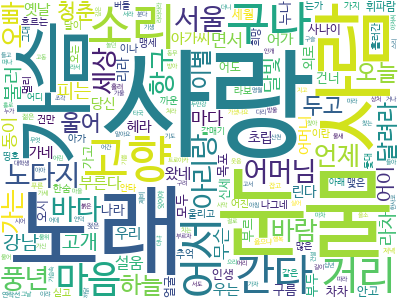

In [94]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

### 당연히 ...
사랑이라는 단어가 가장 많이 나올 것이기 때문에.. Top10 → Top11로 변경

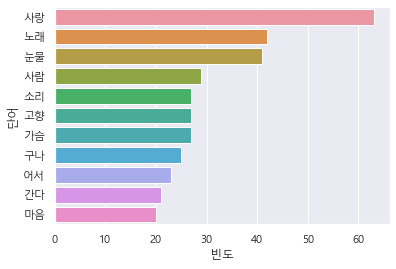

In [95]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

## 연도 칼럼 추가

In [96]:
# 1990 Top11 words
wc11['year'] = '1940y'
wc1940 = wc11
wc1940

,단어,빈도,year
954,사랑,63,1940y
324,노래,42,1940y
353,눈물,41,1940y
953,사람,29,1940y
1043,소리,27,1940y
125,고향,27,1940y
33,가슴,27,1940y
142,구나,25,1940y
1234,어서,23,1940y
46,간다,21,1940y


### 리스트에 담기

In [97]:
wc1940['단어'].unique().tolist()

['사랑', '노래', '눈물', '사람', '소리', '고향', '가슴', '구나', '어서', '간다', '마음']

In [98]:
top_word40 = wc1940['단어'].unique().tolist()

## 다음 연대 결과에 제외시키기 위해 불용어로 추가

In [99]:
stop_w += top_word40

In [100]:
len(stop_w)

131

---

## 1950 년대

In [101]:
# like count 정렬 맞는지 다시 확인
sort_like50.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
98,80078170,추억의 소야곡,남인수,남인수 골든,1061,다시 한 번 그 얼굴이 보고 싶어라 몸부림치며 울며 떠난 사람아 저 달이 밝혀...,https://image.bugsm.co.kr/album/images/200/800...,"['연도별 인기가요', '1950년대', '연대별', '국내', '연대별 음악']",1950y
99,1897305,열아홉 순정,이미자,이미자 골든베스트 2,930,보기만 하여도 울렁 생각만 하여도 울렁 수줍은 열 아홉 살 움트는 첫사랑을 몰라 ...,https://image.bugsm.co.kr/album/images/200/214...,"['연도별 인기가요', '1950년대', '연대별', '국내', '연대별 음악']",1950y


In [102]:
lyric50 = sort_like50.Lyric

In [103]:
tagging_okt = []
for i in lyric50:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)

In [104]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

In [105]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [106]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(6042, 1740)
1740


In [107]:
cv.get_feature_names()[:10]

['가고', '가기', '가나', '가냘퍼', '가네', '가느냐', '가느니', '가는', '가닥', '가더라']

In [108]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
142,그대,43
1177,오동동,30
537,리리,28
195,깜빡,21
1289,이별,19
66,거리,19
1224,운다,18
527,레이,18
7,가는,17
1053,아가씨,17


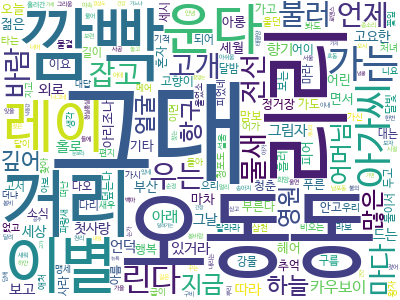

In [109]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

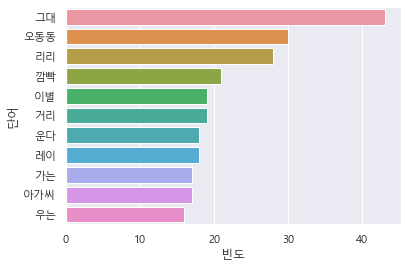

In [110]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [111]:
# 2000 Top11 words
wc11['year'] = '1950y'
wc1950 = wc11
wc1950

,단어,빈도,year
142,그대,43,1950y
1177,오동동,30,1950y
537,리리,28,1950y
195,깜빡,21,1950y
1289,이별,19,1950y
66,거리,19,1950y
1224,운다,18,1950y
527,레이,18,1950y
7,가는,17,1950y
1053,아가씨,17,1950y


In [112]:
top_word50 = wc1950['단어'].unique().tolist()
stop_w += top_word50
len(stop_w)

142

---

## 1960 년대

In [113]:
# like count 정렬 맞는지 다시 확인
sort_like60.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
196,111110,안개낀 장충단 공원,배호,불멸(不滅)의 가수(歌手) 배호(裵湖) 전곡,2966,안개 낀 장충단 공원 누구를 찾아왔나 낙엽송 고목을 말 없이 쓸어 안고 울고만 있...,https://image.bugsm.co.kr/album/images/200/157...,"['연도별 인기가요', '1960년대', '연대별', '국내', '연대별 음악']",1960y
197,65527,카츄샤의 노래,송민도,송민도 히트전집,2580,커피 한 잔을 시켜놓고 그대 올 때를 기다려봐도 왠일인지 오지를 않네 내...,https://image.bugsm.co.kr/album/images/200/50/...,"['연도별 인기가요', '1960년대', '연대별', '국내', '연대별 음악']",1960y


In [114]:
lyric60 = sort_like60.Lyric

In [115]:
tagging_okt = []
for i in lyric60:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)

In [116]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

In [117]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [118]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(5606, 1464)
1464


In [119]:
cv.get_feature_names()[:10]

['가가', '가겠노', '가고', '가나', '가냘픈', '가네', '가느냐', '가는지', '가도', '가득']

In [120]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
1264,짜기,24
705,사나이,24
951,얼굴,21
171,까투리,20
557,바람,20
430,마다,19
970,여자,19
621,보고,18
931,어디,17
1376,하늘,16


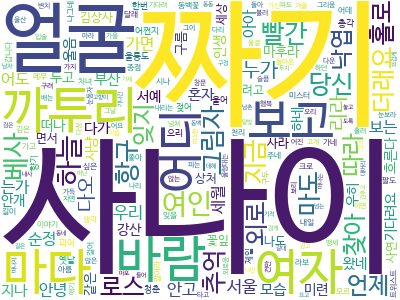

In [121]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

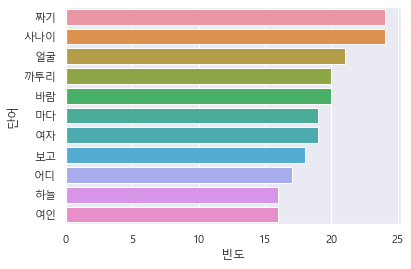

In [122]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [123]:
# 2010 Top11 words
wc11['year'] = '1960y'
wc1960 = wc11
wc1960

,단어,빈도,year
1264,짜기,24,1960y
705,사나이,24,1960y
951,얼굴,21,1960y
171,까투리,20,1960y
557,바람,20,1960y
430,마다,19,1960y
970,여자,19,1960y
621,보고,18,1960y
931,어디,17,1960y
1376,하늘,16,1960y


In [124]:
top_word60 = wc1960['단어'].unique().tolist()
stop_w += top_word60
len(stop_w)

153

---

## 1970 년대

In [125]:
# like count 정렬 맞는지 다시 확인
sort_like70.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
284,80009878,나 어떡해,샌드 페블즈(Sand Pebbless),대학가요제 Forever Golden Best (Best Of Best),8394,나 어떡해 너 갑자기 가버리면 나 어떡해 너를 잃고 살아갈까 나 어떡해 나를...,https://image.bugsm.co.kr/album/images/200/800...,"['국내', '7080', '1970년대', '락', '성인가요', '밴드', '그...",1970y
285,1114634,하얀 나비,김정호,하얀 나비 / 인생,8163,음 생각을 말아요 지나간 일들은 음 그리워 말아요 떠나갈 님인데 꽃잎은 시들어요...,https://image.bugsm.co.kr/album/images/200/113...,"['국내', '포크', '성인가요', '부모님', '통기타', '1970년대', '...",1970y


In [126]:
lyric70 = sort_like70.Lyric

In [127]:
tagging_okt = []
for i in lyric70:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)

In [128]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

In [129]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [130]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(14509, 2584)
2584


In [131]:
cv.get_feature_names()[:10]

['가가', '가거', '가겠소', '가고', '가고있는', '가까이', '가나', '가난', '가내', '가네']

In [132]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
566,당신,87
1801,우리,81
1524,아름,51
935,모두,46
2427,하얀,46
527,다운,43
1335,생각,42
1644,어요,40
2494,행복,39
2301,친구,39


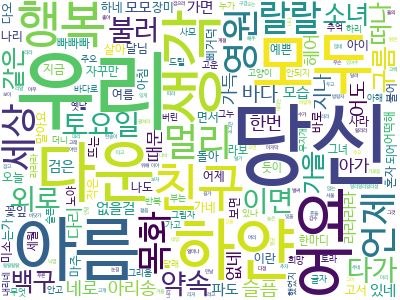

In [133]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

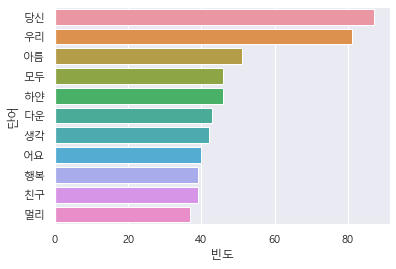

In [134]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [135]:
# 2010 Top11 words
wc11['year'] = '1970y'
wc1970 = wc11
wc1970

,단어,빈도,year
566,당신,87,1970y
1801,우리,81,1970y
1524,아름,51,1970y
935,모두,46,1970y
2427,하얀,46,1970y
527,다운,43,1970y
1335,생각,42,1970y
1644,어요,40,1970y
2494,행복,39,1970y
2301,친구,39,1970y


In [136]:
top_word70 = wc1970['단어'].unique().tolist()
stop_w += top_word70
len(stop_w)

164

---

## 1980 년대

In [137]:
lyric80 = sort_like80.Lyric

In [138]:
tagging_okt = []
for i in lyric80:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)

In [139]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            

In [140]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [141]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(29896, 3755)
3755


In [142]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
1326,모습,160
2184,아무,84
2212,아직,78
3319,추억,76
1966,세월,75
2060,슬픔,75
1018,떠나,72
2492,영원,72
3152,지나,66
1960,세상,66


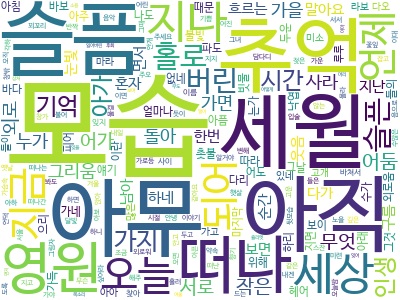

In [143]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()


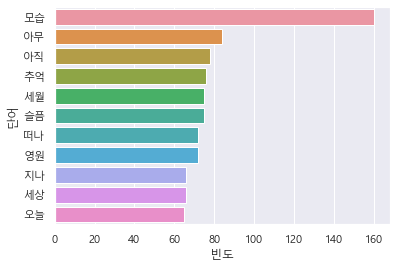

In [144]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [145]:
# 2010 Top11 words
wc11['year'] = '1980y'
wc1980 = wc11
wc1980


,단어,빈도,year
1326,모습,160,1980y
2184,아무,84,1980y
2212,아직,78,1980y
3319,추억,76,1980y
1966,세월,75,1980y
2060,슬픔,75,1980y
1018,떠나,72,1980y
2492,영원,72,1980y
3152,지나,66,1980y
1960,세상,66,1980y


In [146]:
top_word80 = wc1980['단어'].unique().tolist()
stop_w += top_word80
len(stop_w)

175

---

## 1990 년대

In [147]:
lyric90 = sort_like90.Lyric

In [148]:
tagging_okt = []
for i in lyric90:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)

In [149]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

In [150]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [151]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(82748, 5000)
5000


In [152]:
cv.get_feature_names()[:10]

['가게', '가겠', '가겠어', '가겠죠', '가겠지', '가고', '가고만', '가고싶던', '가고있어', '가기']

In [153]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
3021,언제,316
4113,지금,312
2642,시간,239
3379,위해,218
488,기억,215
599,나나,168
3890,조금,162
1011,다른,162
407,그녀,141
4830,혼자,141


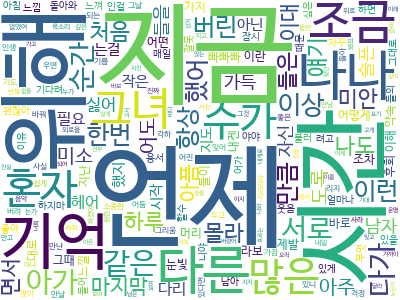

In [154]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

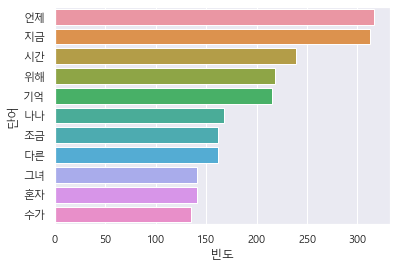

In [155]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [156]:
# 2010 Top11 words
wc11['year'] = '1990y'
wc1990 = wc11
wc1990


,단어,빈도,year
3021,언제,316,1990y
4113,지금,312,1990y
2642,시간,239,1990y
3379,위해,218,1990y
488,기억,215,1990y
599,나나,168,1990y
3890,조금,162,1990y
1011,다른,162,1990y
407,그녀,141,1990y
4830,혼자,141,1990y


In [157]:
top_word90 = wc1990['단어'].unique().tolist()
stop_w += top_word90
len(stop_w)

186

---

## 2000 년대

In [158]:
lyric20 = sort_like20.Lyric

In [159]:
tagging_okt = []
for i in lyric20:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)

In [160]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

In [161]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [162]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(168614, 5000)
5000


In [163]:
cv.get_feature_names()[:10]
#
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
933,다가,360
184,같은,318
3135,어도,297
4699,하루,250
4735,한번,242
731,남자,231
2668,순간,229
1766,몰라,223
2882,아가,218
1954,바보,218


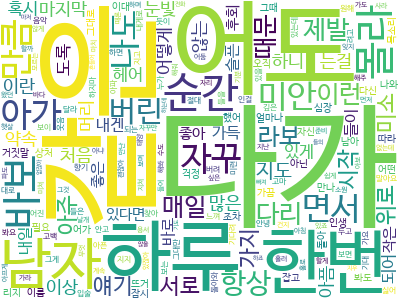

In [164]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

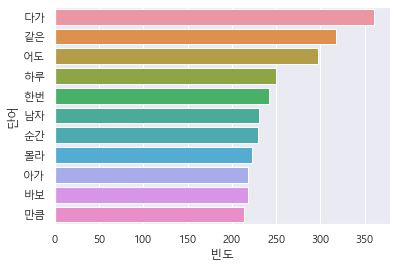

In [165]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [166]:
# 2010 Top11 words
wc11['year'] = '2000y'
wc2000 = wc11
wc2000


,단어,빈도,year
933,다가,360,2000y
184,같은,318,2000y
3135,어도,297,2000y
4699,하루,250,2000y
4735,한번,242,2000y
731,남자,231,2000y
2668,순간,229,2000y
1766,몰라,223,2000y
2882,아가,218,2000y
1954,바보,218,2000y


In [167]:
top_word20 = wc2000['단어'].unique().tolist()
stop_w += top_word20
len(stop_w)

197

---

## 2010 년대

In [168]:
lyric2010 = sort_like2010.Lyric

In [169]:
tagging_okt = []
for i in lyric2010:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)

In [170]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            

In [171]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [172]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(148681, 5000)
5000


In [173]:
cv.get_feature_names()[:10]

['가가', '가게', '가겠지', '가고', '가기', '가까워', '가까이', '가끔', '가나', '가난']

In [174]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
3862,자꾸,300
1695,매일,226
4092,좋아,219
3656,이런,199
1705,머리,175
2115,버린,172
654,나도,161
2926,아래,155
2602,서로,152
1325,들은,143


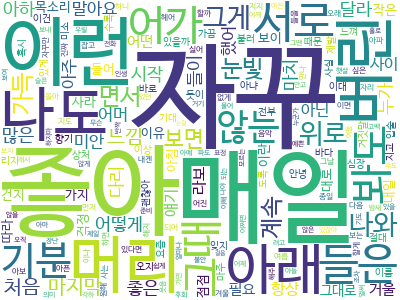

In [175]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

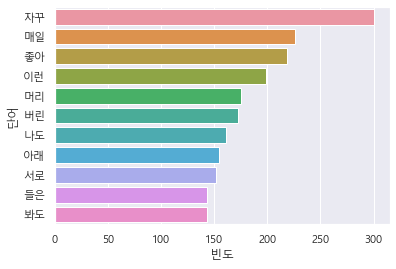

In [176]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [177]:
# 2010 Top11 words
wc11['year'] = '2010y'
wc2010 = wc11
wc2010

,단어,빈도,year
3862,자꾸,300,2010y
1695,매일,226,2010y
4092,좋아,219,2010y
3656,이런,199,2010y
1705,머리,175,2010y
2115,버린,172,2010y
654,나도,161,2010y
2926,아래,155,2010y
2602,서로,152,2010y
1325,들은,143,2010y


In [178]:
# top_word2010 = wc2010['단어'].unique().tolist()
# stop_w += top_word2010
# len(stop_w)

### 연대별 단어 Top11 append
* 1940~ 2010

In [179]:
years_top_word = wc1940.append(wc1950)
years_top_word = years_top_word.append(wc1960)

years_top_word = years_top_word.append(wc1980)
years_top_word = years_top_word.append(wc1990)
years_top_word = years_top_word.append(wc2000)
years_top_word = years_top_word.append(wc2010)
len(years_top_word) 

77

In [180]:
years_top_word = years_top_word.append(wc1970)

In [183]:
len(years_top_word) 

88

In [181]:
years_top_word.reset_index(drop=True)
display(years_top_word.head(3),years_top_word.tail(3))

,단어,빈도,year
954,사랑,63,1940y
324,노래,42,1940y
353,눈물,41,1940y


,단어,빈도,year
2494,행복,39,1970y
2301,친구,39,1970y
911,멀리,37,1970y


In [182]:
years_top_word.to_csv('years_top_word.csv',index=False)

In [ ]:
## 전체코드

In [ ]:
# like count 정렬 맞는지 다시 확인
sort_like60.head(2)
#
lyric60 = sort_like60.Lyric
#
tagging_okt = []
for i in lyric60:
    tag_word = twitter.pos(i)
    tagging_okt.append(tag_word)
#
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            
#
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)
#
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))
#
cv.get_feature_names()[:10]
#
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

# 

WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

#
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

#

# 2010 Top11 words
wc11['year'] = '1960y'
wc1960 = wc11
wc1960


#
top_word60 = wc1960['단어'].unique().tolist()
stop_w += top_word60
len(stop_w)